# How to use noise models in PennyLane?

## 1. Define conditions

Define conditions to select when and where you wanna apply the noise.
Available conditions are as follows:

*   Operation-based conditionals: They evaluate whether a gate operation is a specific type of operation or belongs to a specified set of operations. They are implemented using `op_eq()` and  `op_in()` respectively.

*   Wire-based conditionals: hey evaluate whether a gate operation’s wires are equal to or are contained in a specified set of wires. They are built using `wires_eq()` and `wires_in()`, respectively.

*   Arbitrary conditionals: Custom conditionals can be defined as a function wrapped with a `BooleanFn` decorator. The signature for such conditionals must be `cond_fn(operation: Operation) -> bool`.



In [11]:
import pennylane as qml
import numpy as np

#The arbitrary condition to check if the operation is R_X and its parameter is less than 1.0
@qml.BooleanFn
def rx_cond(op):
    return isinstance(op, qml.RX) and np.abs(op.parameters[0]) < 1.0

# Combine the arbitrary conditional with a wire-based conditional
rx_and_wires_cond = rx_cond & qml.noise.wires_in([0, 1])

#Depolarization error
depol_error = qml.noise.partial_wires(qml.DepolarizingChannel, 0.01)

#Previously defined noise and its condition
fcond1, noise1 = rx_and_wires_cond, depol_error

In [12]:
#Adding another pair to mimic the thermal relaxation errors during the state preparation
fcond2 = qml.noise.op_eq(qml.StatePrep)

def noise2(op, **kwargs):
    for wire in op.wires:
        qml.ThermalRelaxationError(0.1, kwargs["t1"], kwargs["t2"], kwargs["tg"], wire)

Noise can be inserted in a custom order by manually queuing the evaluated gate operation via `apply()` within the function definition


In [13]:
#Adding a sandwiching constant-valued rotation error for Hadamard gates on the wires 0,1
fcond3 = qml.noise.op_eq("Hadamard") & qml.noise.wires_in([0, 1])

def noise3(op, **kwargs):
    qml.RX(np.pi / 16, op.wires)
    qml.apply(op)
    qml.RY(np.pi / 8, op.wires)

## 2. Creating the noise model

Building the noise model with some required `metadata` for `noise2`

In [14]:
metadata = dict(t1=0.02, t2=0.03, tg=0.001)  # times unit: sec
noise_model = qml.NoiseModel(
    {fcond1: noise1, fcond2: noise2, fcond3: noise3}, **metadata
)
print(noise_model)

NoiseModel({
    rx_cond & WiresIn([0, 1]): DepolarizingChannel(p=0.01)
    OpEq(StatePrep): noise2
    OpEq(Hadamard) & WiresIn([0, 1]): noise3
}, t1 = 0.02, t2 = 0.03, tg = 0.001)


## 3. Adding noise model to the workflow

 Noise model can be applied to a circuit or device via the `add_noise()` transform.

 Consider the following circuit that performs the evolution and de-evolution of a given initial state based on some parameters.

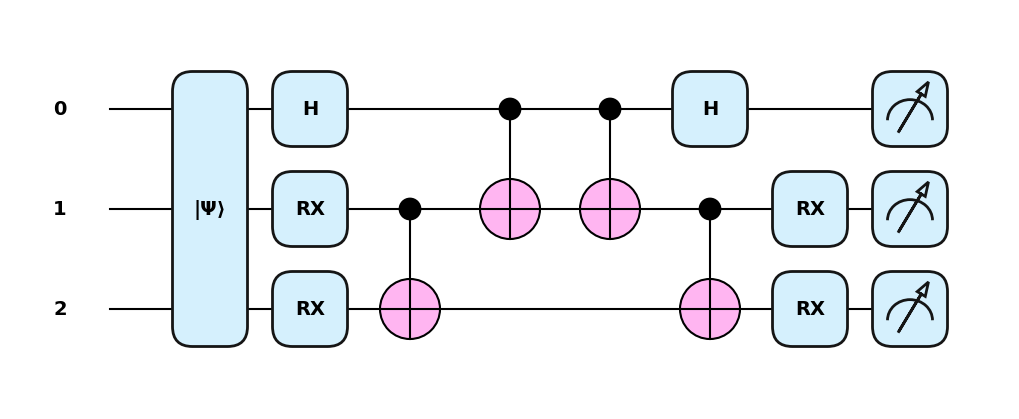

In [15]:
from matplotlib import pyplot as plt

qml.drawer.use_style("pennylane")
dev = qml.device("default.mixed", wires=3)
init_state = np.random.RandomState(42).rand(2 ** len(dev.wires))
init_state /= np.linalg.norm(init_state)

def circuit(theta, phi):
    # State preparation
    qml.StatePrep(init_state, wires=[0, 1, 2])

    # Evolve state
    qml.Hadamard(0)
    qml.RX(theta, 1)
    qml.RX(phi, 2)
    qml.CNOT([1, 2])
    qml.CNOT([0, 1])

    # De-evolve state
    qml.CNOT([0, 1])
    qml.CNOT([1, 2])
    qml.RX(-phi, 2)
    qml.RX(-theta, 1)
    qml.Hadamard(0)
    return qml.state()

theta, phi = 0.21, 0.43
ideal_circuit = qml.QNode(circuit, dev)
qml.draw_mpl(ideal_circuit)(theta, phi)
plt.show()

Adding noise to the ideal_model to create the noisy_model

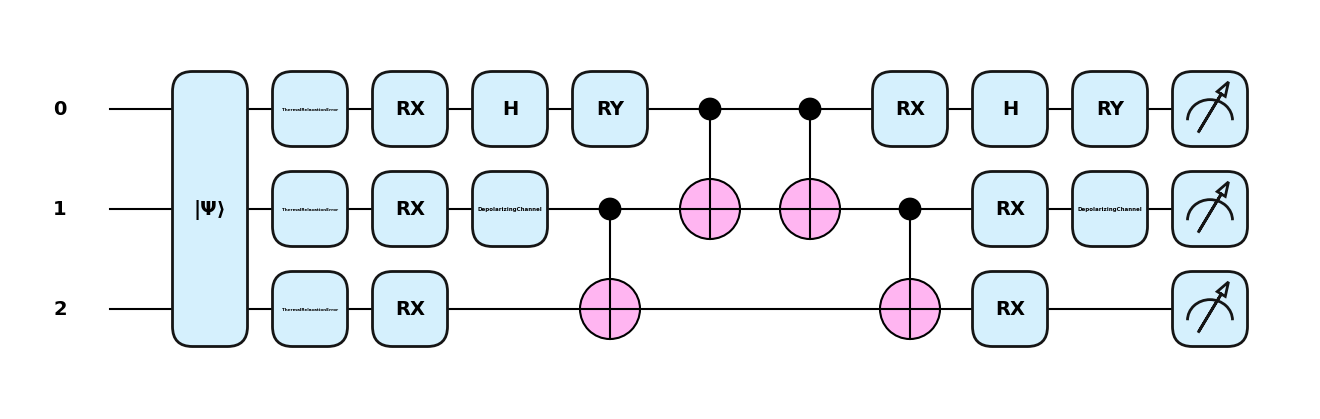

In [16]:
noisy_circuit = qml.add_noise(ideal_circuit, noise_model)
qml.draw_mpl(noisy_circuit)(theta, phi)
plt.show()

## 4. Running the noisy simulation

In [17]:
init_dm = np.outer(init_state, init_state) # density matrix for the init_state
ideal_res = np.round(qml.math.fidelity(ideal_circuit(theta, phi), init_dm), 8)
noisy_res = np.round(qml.math.fidelity(noisy_circuit(theta, phi), init_dm), 8)

print(f"Ideal v/s Noisy: {ideal_res} and {noisy_res}")

Ideal v/s Noisy: 1.00000002 and 0.90174224
